In [1]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
from fredapi import Fred
from scipy.optimize import minimize
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [2]:
# Selecting tickers
tickers = ['ORCL',     # Oracle
           'IBM',      # IBM
           'KO',       # Coca-Cola
           'NKE',      # Nike
           'PFE',      # Pfizer
           'UNH',      # UnitedHealth
           'AMZN',     # Amazon
           'WMT',      # Walmart
           'JPM',      # JP Morgan
           'GS',       # Goldman Sachs
           'BTC-USD',  # Bitcoin
           'ETH-USD',  # Ethereum
           'BNB-USD',  # Binance Coin
           'USDT-USD'  # Tether USDt
           ]

In [3]:
# Defining start date so that 70% of the data correspond to 3 years, approximately
today = datetime.today()
working_days = int((3 / 0.7) * 252)
initial_day = pd.date_range(end=today, periods=working_days, freq='B').min().date()
str(initial_day)

'2020-01-28'

In [4]:
# Extracting adjusted close prices
df = pd.DataFrame()
for i in tickers:
    df[i] = yf.download(i, start = str(initial_day),
                        end = '2024-01-01',
                        progress = False)['Adj Close']

df.head()

,ORCL,IBM,KO,NKE,PFE,UNH,AMZN,WMT,JPM,GS,BTC-USD,ETH-USD,BNB-USD,USDT-USD
Date,,,,,,,,,,,,,,
2020-01-28,50.123829,108.559143,49.916626,96.080788,30.538336,268.714233,92.662498,36.367275,119.148926,218.290237,9358.589844,176.370316,18.115135,1.000760
2020-01-29,49.880047,107.112228,49.916626,95.535378,30.089952,265.922485,92.900002,36.145836,118.971687,216.076523,9316.629883,175.050339,17.912777,1.002296
2020-01-30,49.983192,106.396530,51.536449,93.956535,29.984797,264.117706,93.533997,36.361038,120.443001,219.685043,9508.993164,184.690475,18.590408,1.001452
2020-01-31,49.176849,111.810875,51.133678,92.148003,30.122301,256.099579,100.435997,35.709171,117.314285,213.943848,9350.529297,180.160172,18.210979,1.000648
2020-02-03,49.776909,113.786804,51.291283,94.989944,30.340694,257.575409,100.209999,35.640556,118.209442,215.077682,9293.521484,189.865067,18.462755,0.998913


In [5]:
# Checking if there is missing values
df.isna().sum()

ORCL        0
IBM         0
KO          0
NKE         0
PFE         0
UNH         0
AMZN        0
WMT         0
JPM         0
GS          0
BTC-USD     0
ETH-USD     0
BNB-USD     0
USDT-USD    0
dtype: int64

In [6]:
# Checking the DataFrame shape
df.shape

(989, 14)

In [7]:
# Separating the data between sample and out of sample 
sample = df.iloc[:int(df.shape[0] * 0.7),:]
out_sample = df.iloc[int(df.shape[0] * 0.7):,:]

In [8]:
# Identifying the quantity of lines of each part
print(sample.shape[0])
print(out_sample.shape[0])

692
297


In [9]:
# Calculating the daily log normal returns for each ticker
daily_log_returns = np.log(sample / sample.shift(1))
daily_log_returns = daily_log_returns.dropna()
daily_log_returns.head()

,ORCL,IBM,KO,NKE,PFE,UNH,AMZN,WMT,JPM,GS,BTC-USD,ETH-USD,BNB-USD,USDT-USD
Date,,,,,,,,,,,,,,
2020-01-29,-0.004875,-0.013418,0.000000,-0.005693,-0.014791,-0.010444,0.002560,-0.006108,-0.001489,-0.010193,-0.004494,-0.007512,-0.011234,0.001534
2020-01-30,0.002066,-0.006704,0.031935,-0.016664,-0.003501,-0.006810,0.006801,0.005936,0.012291,0.016562,0.020437,0.053608,0.037132,-0.000842
2020-01-31,-0.016264,0.049636,-0.007846,-0.019436,0.004575,-0.030829,0.071196,-0.018090,-0.026320,-0.026481,-0.016805,-0.024835,-0.020621,-0.000803
2020-02-03,0.012128,0.017518,0.003077,0.030375,0.007224,0.005746,-0.002253,-0.001923,0.007601,0.005286,-0.006115,0.052467,0.013731,-0.001735
2020-02-04,0.017736,0.019230,0.004429,0.021032,0.004787,0.024584,0.022434,0.008713,0.014293,0.012184,-0.012185,-0.003242,-0.015578,0.002831


In [10]:
# Calculating the covariance matrix using the annualized log returns
cov_matrix = daily_log_returns.cov() * 252
cov_matrix

,ORCL,IBM,KO,NKE,PFE,UNH,AMZN,WMT,JPM,GS,BTC-USD,ETH-USD,BNB-USD,USDT-USD
ORCL,0.117584,0.055605,0.041915,0.058547,0.043853,0.057091,0.056851,0.038640,0.070440,0.070405,0.065519,0.090744,0.075793,-0.006855
IBM,0.055605,0.098103,0.050842,0.054333,0.042741,0.056600,0.034818,0.027256,0.077947,0.072889,0.052811,0.074419,0.071649,-0.004803
KO,0.041915,0.050842,0.064659,0.046506,0.036846,0.050644,0.027643,0.027698,0.061713,0.056890,0.038595,0.055310,0.052803,-0.003912
NKE,0.058547,0.054333,0.046506,0.139843,0.034529,0.064152,0.069343,0.029851,0.080089,0.083400,0.084463,0.111483,0.105728,-0.002307
PFE,0.043853,0.042741,0.036846,0.034529,0.091679,0.048972,0.026229,0.025271,0.047942,0.042081,0.026965,0.041780,0.048092,-0.004225
UNH,0.057091,0.056600,0.050644,0.064152,0.048972,0.114812,0.045657,0.034310,0.075461,0.076783,0.058824,0.085276,0.073245,-0.004416
AMZN,0.056851,0.034818,0.027643,0.069343,0.026229,0.045657,0.149366,0.033882,0.045005,0.057860,0.097676,0.123404,0.112404,-0.003341
WMT,0.038640,0.027256,0.027698,0.029851,0.025271,0.034310,0.033882,0.068709,0.027718,0.030163,0.040426,0.062466,0.047759,-0.004963
JPM,0.070440,0.077947,0.061713,0.080089,0.047942,0.075461,0.045005,0.027718,0.152746,0.131750,0.082637,0.100753,0.097194,-0.005216
GS,0.070405,0.072889,0.056890,0.083400,0.042081,0.076783,0.057860,0.030163,0.131750,0.150346,0.098791,0.125763,0.114761,-0.005024


In [11]:
# Calculate the portfolio standard deviation
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)
# @ to multiply matrix

In [12]:
# Calculate the expected return
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

In [13]:
# Calculate the Sharpe Ratio
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [14]:
# Replace 'your_api_key' with your actual FRED API key
fred = Fred(api_key = 'secret')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

In [15]:
# Set the risk-free rate
risk_free_rate = ten_year_treasury_rate.iloc[-1]
risk_free_rate

0.0421

In [16]:
# In the case of the scipy.optimize.minimize() function, there is no direct method to find the maximum value
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

# A otimização tentará minimizar o negativo do índice de Sharpe, o que é equivalente a maximizar o índice de Sharpe

In [17]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]

In [18]:
initial_weights = np.array([1/len(tickers)]*len(tickers))

In [19]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(daily_log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [20]:
optimal_weights = optimized_results.x

In [21]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, daily_log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, daily_log_returns, cov_matrix, risk_free_rate)

print(f"Expected Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
ORCL: 0.0000
IBM: 0.0000
KO: 0.0000
NKE: 0.0000
PFE: 0.0949
UNH: 0.5000
AMZN: 0.0000
WMT: 0.0000
JPM: 0.0000
GS: 0.0000
BTC-USD: 0.0000
ETH-USD: 0.0290
BNB-USD: 0.3761
USDT-USD: 0.0000
Expected Return: 0.5293
Expected Volatility: 0.4974
Sharpe Ratio: 0.9796


In [22]:
formatted_weights = [f"{weight:.4f}" for weight in optimal_weights]
data = list(zip(tickers, formatted_weights))
series = pd.Series(formatted_weights, index=tickers, name='Weight')
series = series.astype(float)
series = series.sort_values(ascending=False)
series

UNH         0.5000
BNB-USD     0.3761
PFE         0.0949
ETH-USD     0.0290
ORCL        0.0000
IBM         0.0000
KO          0.0000
NKE         0.0000
AMZN        0.0000
WMT         0.0000
JPM         0.0000
GS          0.0000
BTC-USD     0.0000
USDT-USD    0.0000
Name: Weight, dtype: float64

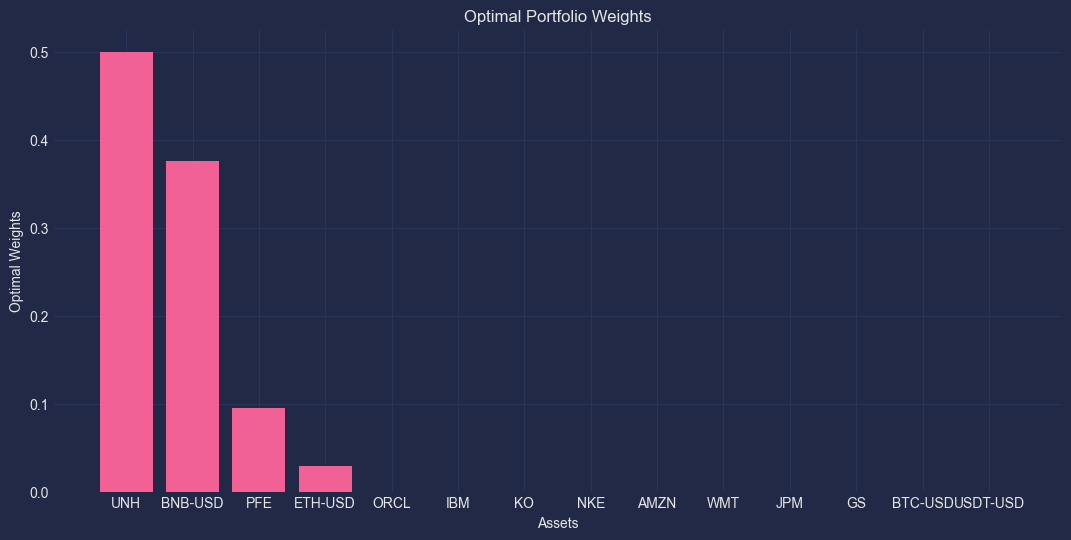

In [23]:
# Import
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# Create a bar chart of the optimal weights
plt.figure(figsize=(13, 6))
plt.bar(series.index, series, color = '#f26196')

# Add labels and title
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

# Show the plot
plt.show()

In [24]:
# Calculate the lognormal returns for each ticker
daily_log_returns = np.log(out_sample / out_sample.shift(1))

In [25]:
# Drop any missing values
daily_log_returns = daily_log_returns.dropna()

In [26]:
daily_log_returns.head()

,ORCL,IBM,KO,NKE,PFE,UNH,AMZN,WMT,JPM,GS,BTC-USD,ETH-USD,BNB-USD,USDT-USD
Date,,,,,,,,,,,,,,
2022-10-26,0.022710,0.015526,0.007436,0.007278,0.010257,0.005446,-0.041824,0.007610,0.011426,0.009849,0.033017,0.069310,0.020684,-0.000009
2022-10-27,0.004401,-0.001779,0.002354,-0.020227,-0.006972,-0.002525,-0.041485,-0.002909,0.003940,0.004429,-0.023608,-0.033884,-0.012241,-0.000107
2022-10-28,0.028984,0.027372,0.020451,0.035693,0.036282,0.017273,-0.070468,0.012569,0.011808,0.013667,0.015142,0.026780,0.038202,0.000054
2022-10-31,0.009136,-0.001589,-0.015090,-0.012332,-0.018728,0.007068,-0.009424,-0.001264,-0.001588,0.007839,-0.004847,0.011020,0.090862,-0.000199
2022-11-01,-0.012373,-0.000651,-0.003515,0.011692,0.030882,-0.014223,-0.056734,-0.004507,0.017872,0.011744,-0.000512,0.004435,-0.005473,-0.000023


In [27]:
# Create naive portfolio
num_assets = len(df.columns)
n = 1 / float(num_assets)
naive_weights = [n] * num_assets
naive_weights = np.array(naive_weights)
naive_weights

array([0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857, 0.07142857,
       0.07142857, 0.07142857, 0.07142857, 0.07142857])

In [28]:
meanDailyReturns = daily_log_returns.mean()
portReturns = np.sum(meanDailyReturns*series)
portReturns

2.6093944014400432e-05

In [29]:
daily_log_returns.tail()

,ORCL,IBM,KO,NKE,PFE,UNH,AMZN,WMT,JPM,GS,BTC-USD,ETH-USD,BNB-USD,USDT-USD
Date,,,,,,,,,,,,,,
2023-12-22,0.003207,0.008423,0.005674,-0.125854,0.003174,0.000827,-0.002734,0.011880,-0.000597,0.000210,0.002931,0.038104,0.000479,0.000796
2023-12-26,-0.000094,0.006578,0.004107,-0.000185,0.000352,-0.000538,-0.000065,-0.001533,0.005897,0.002519,-0.034158,-0.041717,0.092556,-0.000709
2023-12-27,-0.002357,0.001531,0.002558,-0.008273,0.007015,0.005293,-0.000456,0.009355,0.005980,0.007493,0.021462,0.063912,0.083684,0.000461
2023-12-28,0.002922,0.001772,0.000681,0.015652,0.006272,0.004028,0.000261,-0.001965,0.005299,0.005007,-0.018938,-0.013192,-0.000242,0.000491
2023-12-29,-0.007748,-0.001222,0.003059,-0.002300,0.000000,0.002986,-0.009433,0.000508,-0.001175,-0.001658,-0.012474,-0.020170,-0.030498,-0.000736


In [30]:
portfolio_returns = pd.DataFrame()
portfolio_returns['Naive Portfolio'] = daily_log_returns.dot(naive_weights)
portfolio_returns['Historical Portfolio'] = daily_log_returns.dot(series)

In [31]:
portfolio_returns.tail()

,Naive Portfolio,Historical Portfolio
Date,,
2023-12-22,-0.003820,0.002000
2023-12-26,0.002358,0.033365
2023-12-27,0.014118,0.036639
2023-12-28,0.000575,0.002136
2023-12-29,-0.005776,-0.010562


In [32]:
daily_cumulative_returns = (1+portfolio_returns).cumprod()
daily_cumulative_returns

,Naive Portfolio,Historical Portfolio
Date,,
2022-10-26,1.012765,1.013486
2022-10-27,1.003317,1.005873
2022-10-28,1.018640,1.033258
2022-10-31,1.023068,1.070713
2022-11-01,1.021505,1.064170
...,...,...
2023-12-22,1.178195,0.912762
2023-12-26,1.180973,0.943216
2023-12-27,1.197646,0.977775


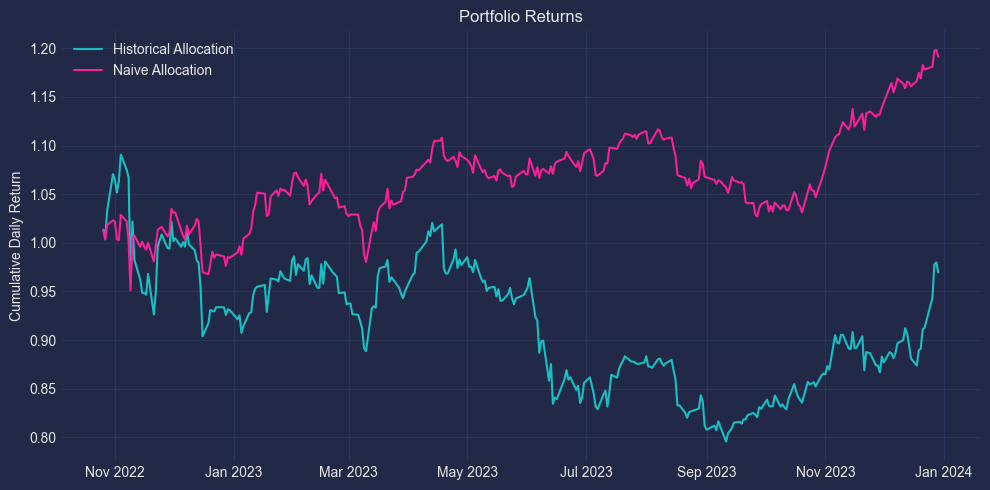

In [36]:
# Dados de exemplo
x = daily_cumulative_returns.index
y1 = daily_cumulative_returns['Historical Portfolio']
y2 = daily_cumulative_returns['Naive Portfolio']

# Criando o gráfico
plt.figure(figsize=(10, 5))
plt.plot(x, y1, label='Historical Allocation')
plt.plot(x, y2, label='Naive Allocation')

# Formatando os rótulos do eixo x para exibir nomes de meses e ano
date_form = DateFormatter("%b %Y")
plt.gca().xaxis.set_major_formatter(date_form)

# Adicionando título e rótulos dos eixos
plt.title('Portfolio Returns')
plt.ylabel('Cumulative Daily Return')

# Adicionando legenda
plt.legend()

# Exibindo o gráfico
plt.tight_layout()  # Ajustando o layout para evitar sobreposição de texto
plt.show()

In [37]:
fig = go.Figure()

# Adicionando a linha do portfólio
fig.add_trace(go.Scatter(x=daily_cumulative_returns.index, y=daily_cumulative_returns['Historical Portfolio'], mode='lines', name='Historical Allocation'))

# Adicionando a primeira linha adicional
fig.add_trace(go.Scatter(x=daily_cumulative_returns.index, y=daily_cumulative_returns['Naive Portfolio'], mode='lines', name='Naive Allocation'))

fig.update_layout(title='Portfolio Returns',
                  yaxis_title='Cumulative Daily Return',
                  width=1000,
                  height=500)

# Exibindo o gráfico
fig.show()

References
* https://www.youtube.com/watch?v=xpUpwEsMV9Y